In [1]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = r"NeoJaundice\chd_jaundice_published_2.csv"
IMG_DIR = r"NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [2]:
df.describe()

,patient_id,gestational_age,age(day),weight,blood(mg/dL),Treatment
count,2235.000000,2235.000000,2229.000000,2235.000000,2235.000000,2235.000000
mean,747.554362,38.293960,6.599192,3158.778523,11.206846,0.417450
std,420.653073,1.807409,5.703538,529.903610,5.213196,0.493249
min,1.000000,30.000000,0.100000,1690.000000,0.000000,0.000000
25%,356.000000,37.000000,2.500000,2800.000000,7.400000,0.000000
50%,794.000000,39.000000,5.000000,3180.000000,11.800000,0.000000
75%,1139.000000,40.000000,9.000000,3500.000000,15.100000,1.000000
max,1351.000000,42.000000,34.000000,5290.000000,25.700000,1.000000


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_mask_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def extract_yellow_card_mask(img):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    return extract_mask_hsv(img, lower_yellow, upper_yellow)

def extract_white_card_mask(img):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    return extract_mask_hsv(img, lower_white, upper_white)

def extract_black_card_mask(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    return extract_mask_hsv(img, lower_black, upper_black)

def extract_red_card_mask(img):
    lower_red1 = np.array([0, 100, 20])
    upper_red1 = np.array([5, 255, 255])
    return extract_mask_hsv(img, lower_red1, upper_red1)


def compute_patch_means(lab_img, patch_mask):
    patch_pixels = lab_img[patch_mask > 0]
    if patch_pixels.size == 0:
        return None
    L = patch_pixels[:,0]
    A = patch_pixels[:,1]
    B = patch_pixels[:,2]
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color_multicard(full_img, yellow_mask, white_mask, black_mask, red_mask,
                                  target_lab_yellow, target_lab_white, target_lab_black, target_lab_red):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)

    yellow_means = compute_patch_means(lab_full, yellow_mask)
    white_means = compute_patch_means(lab_full, white_mask)
    black_means = compute_patch_means(lab_full, black_mask)
    red_means = compute_patch_means(lab_full, red_mask)

    if None in (yellow_means, white_means, black_means, red_means):
        print("One or more patches not detected properly. Skipping correction.")
        return full_img

    L_y, A_y, B_y = yellow_means
    L_w, A_w, B_w = white_means
    L_b, A_b, B_b = black_means
    L_r, A_r, B_r = red_means

    delta_L = np.mean([target_lab_yellow[0] - L_y,
                       target_lab_white[0] - L_w,
                       target_lab_black[0] - L_b,
                       target_lab_red[0] - L_r ])
    delta_A = np.mean([target_lab_yellow[1] - A_y,
                       target_lab_white[1] - A_w,
                       target_lab_black[1] - A_b,
                       target_lab_red[1] - A_r])
    delta_B = np.mean([target_lab_yellow[2] - B_y,
                       target_lab_white[2] - B_w,
                       target_lab_black[2] - B_b,
                       target_lab_red[2] - B_r ])

    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)

    return corrected_bgr


In [4]:
import cv2
import numpy as np
bgr = [0,0, 255]
lab = cv2.cvtColor( np.uint8([[bgr]] ), cv2.COLOR_BGR2LAB)[0][0]
print(lab)  

[136 208 195]


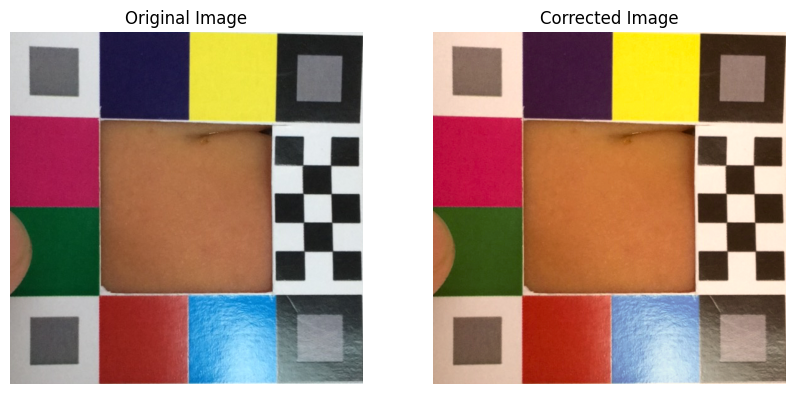

In [5]:
img = image_data[22]


target_lab_yellow = (242.0, 128.0, 223.0)
target_lab_white = (255.0, 128.0, 128.0)
target_lab_black = (0.0, 128.0, 128.0)
target_lab_red = (136.0, 188.0, 195.0)  


yellow_mask = extract_yellow_card_mask(img)
white_mask = extract_white_card_mask(img)
black_mask = extract_black_card_mask(img)
red_mask = extract_red_card_mask(img)

corrected_img = correct_image_color_multicard(
    img, yellow_mask, white_mask, black_mask, red_mask,
    target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
)


# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
plt.title("Corrected Image")
plt.axis('off')

plt.show()


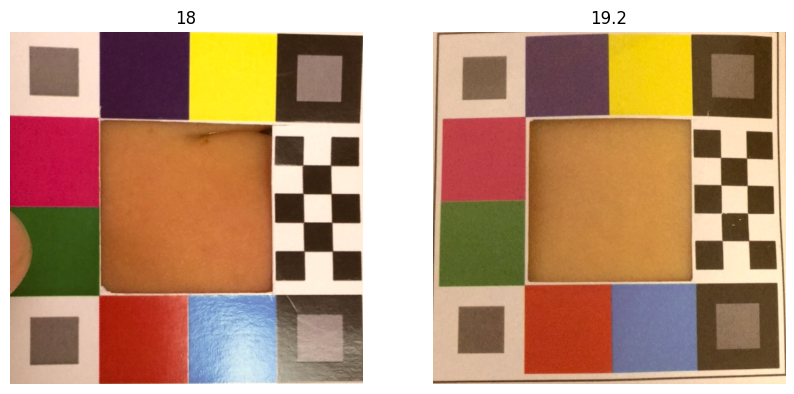

In [6]:
img = image_data[22]


target_lab_yellow = (242.0, 128.0, 223.0)
target_lab_white = (255.0, 128.0, 128.0)
target_lab_black = (0.0, 128.0, 128.0)
target_lab_red = (136.0, 188.0, 195.0)  


yellow_mask = extract_yellow_card_mask(img)
white_mask = extract_white_card_mask(img)
black_mask = extract_black_card_mask(img)
red_mask = extract_red_card_mask(img)

corrected_img = correct_image_color_multicard(
    img, yellow_mask, white_mask, black_mask, red_mask,
    target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
)

corrected_img1 = correct_image_color_multicard(
    image_data[344], yellow_mask, white_mask, black_mask, red_mask,
    target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
plt.title("18")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_img1, cv2.COLOR_BGR2RGB))
plt.title(labels[344])
plt.axis('off')

plt.show()


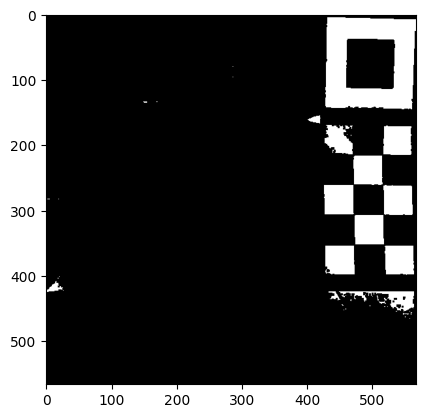

In [7]:
plt.imshow(cv2.cvtColor(black_mask, cv2.COLOR_BGR2RGB))

In [8]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


In [9]:
# import numpy as np
# import cv2
# from sklearn.cluster import KMeans
# from collections import Counter
# import pprint
# from matplotlib import pyplot as plt


# def extractSkin(image):
#     img = image.copy()
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
#     upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
#     skinMask = cv2.inRange(img, lower_threshold, upper_threshold)
#     skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
#     skin = cv2.bitwise_and(img, img, mask=skinMask)
#     return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


# def removeBlack(estimator_labels, estimator_cluster):
#     hasBlack = False
#     occurance_counter = Counter(estimator_labels)
#     def compare(x, y): return Counter(x) == Counter(y)
#     for x in occurance_counter.most_common(len(estimator_cluster)):
#         color = [int(i) for i in estimator_cluster[x[0]].tolist()]
#         if compare(color, [0, 0, 0]) == True:
#             del occurance_counter[x[0]]
#             hasBlack = True
#             estimator_cluster = np.delete(estimator_cluster, x[0], 0)
#             break

#     return (occurance_counter, estimator_cluster, hasBlack)


# def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):
#     occurance_counter = None
#     colorInformation = []
#     hasBlack = False
#     if hasThresholding == True:

#         (occurance, cluster, black) = removeBlack(
#             estimator_labels, estimator_cluster)
#         occurance_counter = occurance
#         estimator_cluster = cluster
#         hasBlack = black

#     else:
#         occurance_counter = Counter(estimator_labels)

#     totalOccurance = sum(occurance_counter.values())

#     for x in occurance_counter.most_common(len(estimator_cluster)):

#         index = (int(x[0]))

#         index = (index-1) if ((hasThresholding & hasBlack)
#                               & (int(index) != 0)) else index

#         color = estimator_cluster[index].tolist()

#         color_percentage = (x[1]/totalOccurance)

#         colorInfo = {"cluster_index": index, "color": color,
#                      "color_percentage": color_percentage}

#         colorInformation.append(colorInfo)

#     return colorInformation


# def extractDominantColor(image, number_of_colors=5, hasThresholding=False):
#     if hasThresholding == True:
#         number_of_colors += 1

#     img = image.copy()
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.reshape((img.shape[0]*img.shape[1]), 3)
#     estimator = KMeans(n_clusters=number_of_colors, random_state=0)
#     estimator.fit(img)
#     colorInformation = getColorInformation(
#         estimator.labels_, estimator.cluster_centers_, hasThresholding)
#     return colorInformation


# def plotColorBar(colorInformation):
#     color_bar = np.zeros((100, 500, 3), dtype="uint8")

#     top_x = 0
#     for x in colorInformation:
#         bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

#         color = tuple(map(int, (x['color'])))

#         cv2.rectangle(color_bar, (int(top_x), 0),
#                       (int(bottom_x), color_bar.shape[0]), color, -1)
#         top_x = bottom_x
#     return color_bar



# def prety_print_data(color_info):
#     for x in color_info:
#         print(pprint.pformat(x))
#         print()



# image = image_data[14]
# plt.subplot(3, 1, 1)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.title("Original Image")

# skin = extractSkin(image)

# plt.subplot(3, 1, 2)
# plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
# plt.title("Thresholded  Image")

# dominantColors = extractDominantColor(skin, hasThresholding=True)

# print("Color Information")
# prety_print_data(dominantColors)

# print("Color Bar")
# colour_bar = plotColorBar(dominantColors)
# plt.subplot(3, 1, 3)
# plt.axis("off")
# plt.imshow(colour_bar)
# plt.title("Color Bar")

# plt.tight_layout()
# plt.show()

In [10]:
# def extract_features_from_image(image):
#     skin = extract_skin_roi(image)
#     dominant_color_info = extractDominantColor(skin, number_of_colors=3, hasThresholding=True)
    
#     if len(dominant_color_info) == 0:
#         return [0, 0, 0, 0]  

#     dominant_rgb = dominant_color_info[0]['color']
#     r, g, b = dominant_rgb
#     X = 0.4125*r + 0.3576*g + 0.1804*b
#     Y = 0.2127*r + 0.7152*g + 0.0722*b
#     Z = 0.0193*r + 0.1192*g + 0.9503*b
#     YI = 100 * (1.3013 * X - 1.1498 * Z) / (Y + 1e-8)

#     return [r, g, b, YI]
# idx=22

# print(labels[idx])
# extract_features_from_image(image_data[idx])

In [11]:
# import csv
# import os
# import numpy as np

# def extract_features_from_image(image):
#     skin = extract_skin_roi(image)
    
#     # 1. Extract dominant RGB and YI
#     dominant_color_info = extractDominantColor(skin, number_of_colors=3, hasThresholding=True)
    
#     if len(dominant_color_info) == 0:
#         return [0, 0, 0, 0, 0]  # Default values if no skin ROI
    
#     r, g, b = dominant_color_info[0]['color']
    
#     # Calculate YI (Yellow Index)
#     X = 0.4125 * r + 0.3576 * g + 0.1804 * b
#     Y = 0.2127 * r + 0.7152 * g + 0.0722 * b
#     Z = 0.0193 * r + 0.1192 * g + 0.9503 * b
#     YI = 100 * (1.3013 * X - 1.1498 * Z) / (Y + 1e-8)
    
#     # 2. Compute Y profile mean
#     bgr = skin.astype(np.float32) / 255  
#     K = 1 - np.max(bgr, axis=2)
#     epsilon = 1e-10
#     Y_profile = (1 - bgr[..., 0] - K) / (1 - K + epsilon)
#     Y_mean = Y_profile[:, Y_profile.shape[1] // 2].mean()  # Middle column mean
    
#     return [r, g, b, YI, Y_mean]

# def create_feature_csv(image_data, labels, output_filename='Yellowness_profile.csv'):
#     """
#     Creates a CSV file with:
#     - Image Index
#     - R, G, B (dominant color)
#     - YI (Yellow Index)
#     - Y Profile Mean (middle column)
#     - Bilirubin (from labels)
#     """
#     rows = []
#     for idx, image in enumerate(image_data):
#         features = extract_features_from_image(image)
#         bilirubin = labels[idx]  # Get bilirubin from labels
#         row = [idx] + features + [bilirubin]
#         rows.append(row)
    
#     # Write to CSV
#     with open(output_filename, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Image Index', 'R', 'G', 'B', 'YI', 'Y Profile Mean', 'Bilirubin'])
#         writer.writerows(rows)
    
#     print(f"CSV saved to: {os.path.abspath(output_filename)}")


# create_feature_csv(image_data, labels)  # Default filename
# # create_feature_csv(image_data, labels, 'custom_features.csv')  # Custom filename

In [12]:
# import csv
# import os

# def create_feature_csv(image_data, labels, output_filename='image_features.csv'):

#     rows = []
#     for idx, image in enumerate(image_data):
#         features = extract_features_from_image(image)
#         bilirubin = labels[idx] 
#         row = [idx] + features + [bilirubin]  #
#         rows.append(row)
    
#     with open(output_filename, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Image Index', 'R', 'G', 'B', 'YI', 'Bilirubin'])
#         writer.writerows(rows)
    
#     print(f"Feature CSV created successfully at {os.path.abspath(output_filename)}")

# create_feature_csv(image_data, labels)  # Creates 'image_features.csv'


In [13]:
# import cv2
# import numpy as np
# image = image_data[22] 
# skin = extract_skin_roi(image)
# bgr = skin.astype(np.float32) / 255  
# K = 1 - np.max(bgr, axis=2)
# epsilon = 1e-10
# Y = (1 - bgr[..., 0] - K) / (1 - K + epsilon)
# middle_column = Y[:, Y.shape[1] // 2] 
# print("Y Profile (middle column):")
# print(middle_column.mean())

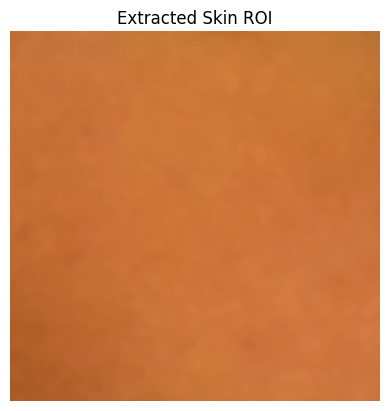

In [14]:
skin_roi = extract_skin_roi(corrected_img)
skin_roi=cv2.medianBlur(skin_roi,5)
plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [15]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [16]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    target_lab_yellow = (242.0, 128.0, 223.0)
    target_lab_white = (255.0, 128.0, 128.0)
    target_lab_black = (0.0, 128.0, 128.0)
    target_lab_red = (136.0, 188.0, 195.0)


    yellow_mask = extract_yellow_card_mask(img)
    white_mask = extract_white_card_mask(img)
    black_mask = extract_black_card_mask(img)
    red_mask = extract_red_card_mask(img)

    corrected_img = correct_image_color_multicard(
        img, yellow_mask, white_mask, black_mask, red_mask,
        target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
    )

    skin_roi = extract_skin_roi(corrected_img)
    skin_roi=cv2.medianBlur(skin_roi,5)

    return extract_color_spaces(skin_roi)


In [17]:
skin_roi.shape

(198, 198, 3)

In [18]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)


One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properl

In [19]:
import numpy as np
color=processed_rgb[413]
mean = color.mean(axis=0)
median = np.median(color, axis=0)
std_dev = color.std(axis=0)
min_val = color.min(axis=0)
max_val = color.max(axis=0)

stats = {
    "Channel": ["R", "G", "B"],
    "Mean": mean,
    "Median": median,
    "Std Dev": std_dev,
    "Min": min_val,
    "Max": max_val
}
for i, channel in enumerate(stats["Channel"]):
    print(f"{channel} channel:")
    print(f"  Mean     : {mean[i]:.2f}")
    print(f"  Median   : {median[i]}")
    print(f"  Std Dev  : {std_dev[i]:.2f}")
    print(f"  Min      : {min_val[i]}")
    print(f"  Max      : {max_val[i]}")
    print()
print(labels[243])


R channel:
  Mean     : 158.98
  Median   : 159.0
  Std Dev  : 10.85
  Min      : 134
  Max      : 184

G channel:
  Mean     : 147.61
  Median   : 147.0
  Std Dev  : 3.27
  Min      : 141
  Max      : 156

B channel:
  Mean     : 169.06
  Median   : 169.0
  Std Dev  : 1.28
  Min      : 164
  Max      : 173

11.9


In [20]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)

print(rgb_scaled.shape)


(2235, 3, 16384)


In [21]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=42)

In [22]:
print(processed_rgb.shape)
print(rgb_scaled.shape)
print(rgb_flat_scaled.shape)

(2235, 16384, 3)
(2235, 3, 16384)
(2235, 49152)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

def conv_branch(input_tensor):
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    return x

def build_rgb_hsv_concat_model(input_shape):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    rgb_features = conv_branch(rgb_input)
    hsv_input = Input(shape=input_shape, name='hsv_input')
    hsv_features = conv_branch(hsv_input)

    combined = Concatenate()([rgb_features, hsv_features])
    
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    

    output = Dense(1, activation='relu')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_hsv_concat_model(input_shape)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 3, 32)                1572896   ['rgb_input[0][0]']           
                                                                                                  
 conv1d_4 (Conv1D)           (None, 3, 32)                1572896   ['hsv_input[0][0]']           
                                                                                              

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=2)
]

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_data=([rgb_val, hsv_val], y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/150
49/49 [==============================] - 5s 74ms/step - loss: 60.4105 - mae: 6.4160 - val_loss: 29.1607 - val_mae: 4.4888 - lr: 1.0000e-04
Epoch 2/150
49/49 [==============================] - 3s 64ms/step - loss: 32.8485 - mae: 4.7187 - val_loss: 26.0530 - val_mae: 4.3363 - lr: 1.0000e-04
Epoch 3/150
49/49 [==============================] - 3s 59ms/step - loss: 29.3076 - mae: 4.4838 - val_loss: 23.8013 - val_mae: 4.1632 - lr: 1.0000e-04
Epoch 4/150
49/49 [==============================] - 3s 61ms/step - loss: 22.8758 - mae: 3.8942 - val_loss: 16.4562 - val_mae: 3.2762 - lr: 1.0000e-04
Epoch 5/150
49/49 [==============================] - 3s 60ms/step - loss: 19.8865 - mae: 3.6047 - val_loss: 12.5212 - val_mae: 2.7948 - lr: 1.0000e-04
Epoch 6/150
49/49 [==============================] - 3s 59ms/step - loss: 18.9550 - mae: 3.4262 - val_loss: 12.7602 - val_mae: 2.8042 - lr: 1.0000e-04
Epoch 7/150
49/49 [==============================] - 3s 56ms/step - loss: 17.3093 - mae: 3.276

In [112]:
test_loss, test_mae = model.evaluate([rgb_test, hsv_test], y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_test, hsv_test])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")



15/15 - 0s - loss: 10.7562 - mae: 2.5422 - 179ms/epoch - 12ms/step
Test Loss (MSE): 10.7562
Test MAE: 2.5422
15/15 [==============================] - 0s 7ms/step
RMSE: 3.280
R²: 0.621


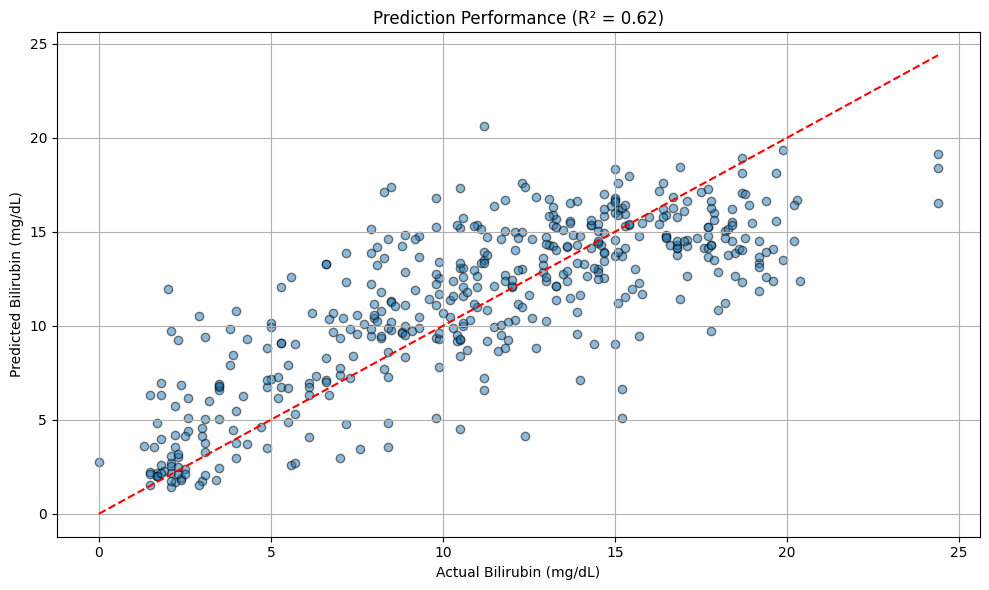

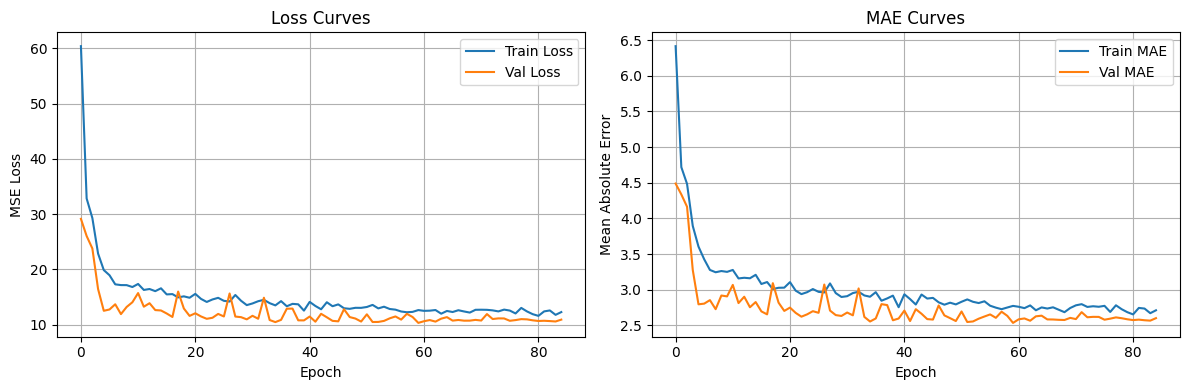

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


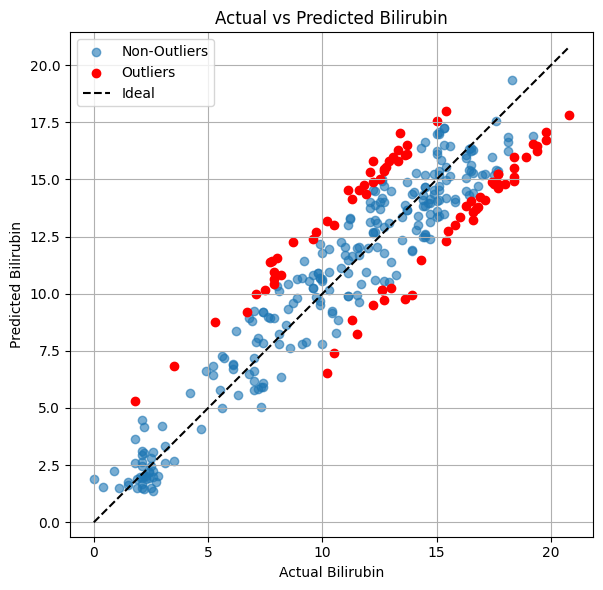

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure NumPy arrays for safe indexing
y_true = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

# Identify outliers based on top 5% absolute error
absolute_error = np.abs(y_true - y_pred)
threshold = np.percentile(absolute_error, 75)
is_outlier = absolute_error > threshold

# Scatter plot: Actual vs Predicted with outliers in red
plt.figure(figsize=(6, 6))
plt.scatter(y_true[~is_outlier], y_pred[~is_outlier], label="Non-Outliers", alpha=0.6)
plt.scatter(y_true[is_outlier], y_pred[is_outlier], color="red", label="Outliers")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label="Ideal")
plt.xlabel("Actual Bilirubin")
plt.ylabel("Predicted Bilirubin")
plt.title("Actual vs Predicted Bilirubin")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [150]:
from sklearn.metrics import mean_absolute_error, r2_score

# Filter non-outliers
y_true_filtered = y_true[~is_outlier]
y_pred_filtered = y_pred[~is_outlier]

# Compute new metrics
filtered_mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
filtered_r2 = r2_score(y_true_filtered, y_pred_filtered)

print(f"Filtered MAE (non-outliers): {filtered_mae:.3f}")
print(f"Filtered R² (non-outliers): {filtered_r2:.3f}")


Filtered MAE (non-outliers): 1.093
Filtered R² (non-outliers): 0.929


In [132]:
# Get predictions for the full dataset
all_preds = model.predict([rgb_scaled, hsv_scaled])
residuals = np.abs(processed_labels - all_preds.flatten())

# Determine top 5% threshold
threshold = np.percentile(residuals, 75)

# Keep only non-outliers
non_outlier_indices = np.where(residuals <= threshold)[0]

# Filter data
rgb_filtered = rgb_scaled[non_outlier_indices]
hsv_filtered = hsv_scaled[non_outlier_indices]
labels_filtered = processed_labels[non_outlier_indices]

print("Filtered data shape:", rgb_filtered.shape)


70/70 [==============================] - 1s 15ms/step
Filtered data shape: (1676, 3, 16384)


In [134]:
from sklearn.model_selection import train_test_split

rgb_train, rgb_test, hsv_train, hsv_test, y_train, y_test = train_test_split(
    rgb_filtered, hsv_filtered, labels_filtered, test_size=0.2, random_state=42)


Text(0.5, 1.0, 'Distribution of test')

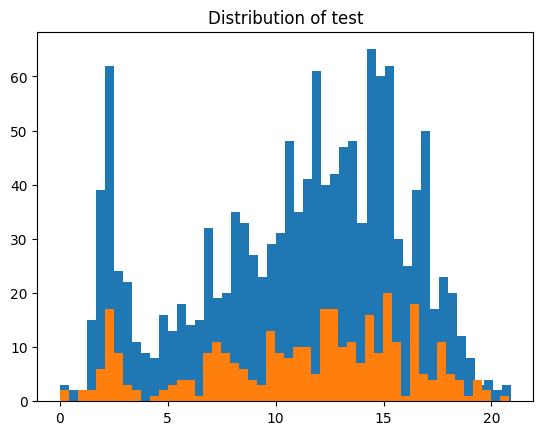

In [149]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=50)
plt.title("Distribution of train")

import matplotlib.pyplot as plt
plt.hist(y_test.flatten(), bins=50)
plt.title("Distribution of test")

In [135]:
# Build the model again (reuse your `build_rgb_hsv_concat_model`)
input_shape = rgb_train.shape[1:]
model = build_rgb_hsv_concat_model(input_shape)

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
34/34 [==============================] - 5s 74ms/step - loss: 60.9145 - mae: 6.4306 - val_loss: 25.1907 - val_mae: 4.3330 - lr: 1.0000e-04
Epoch 2/150
34/34 [==============================] - 3s 74ms/step - loss: 29.3209 - mae: 4.4605 - val_loss: 21.5221 - val_mae: 3.7998 - lr: 1.0000e-04
Epoch 3/150
34/34 [==============================] - 4s 124ms/step - loss: 24.9651 - mae: 4.1440 - val_loss: 17.2678 - val_mae: 3.4179 - lr: 1.0000e-04
Epoch 4/150
34/34 [==============================] - 4s 119ms/step - loss: 20.5186 - mae: 3.7203 - val_loss: 10.6243 - val_mae: 2.7174 - lr: 1.0000e-04
Epoch 5/150
34/34 [==============================] - 3s 90ms/step - loss: 15.4682 - mae: 3.2113 - val_loss: 5.4847 - val_mae: 1.9481 - lr: 1.0000e-04
Epoch 6/150
34/34 [==============================] - 3s 84ms/step - loss: 11.9155 - mae: 2.7325 - val_loss: 5.1433 - val_mae: 1.8412 - lr: 1.0000e-04
Epoch 7/150
34/34 [==============================] - 3s 83ms/step - loss: 10.7253 - mae: 2.553

In [136]:
test_loss, test_mae = model.evaluate([rgb_test, hsv_test], y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_test, hsv_test])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

11/11 - 0s - loss: 3.4319 - mae: 1.5497 - 111ms/epoch - 10ms/step
Test Loss (MSE): 3.4319
Test MAE: 1.5497
11/11 [==============================] - 0s 7ms/step
RMSE: 1.853
R²: 0.854


In [27]:
import pandas as pd

dataf = pd.read_csv('Yellowness_profile.csv')  # Replace with your filename
print(dataf.head())  # Check the structure

   Image Index           R           G           B         YI  Y Profile Mean  \
0            0  166.358032  111.885810   90.905104  36.362156        0.459311   
1            1  192.929917  131.253803  109.050921  34.188463        0.444200   
2            2  187.332665  136.043112  118.151434  27.252404        0.385050   
3            3  181.089822  130.155296   89.140153  43.061965        0.579317   
4            4  153.609306  106.307956   74.961057  43.496995        0.523616   

   Bilirubin  
0        3.9  
1        3.9  
2        3.9  
3       12.2  
4       12.2  


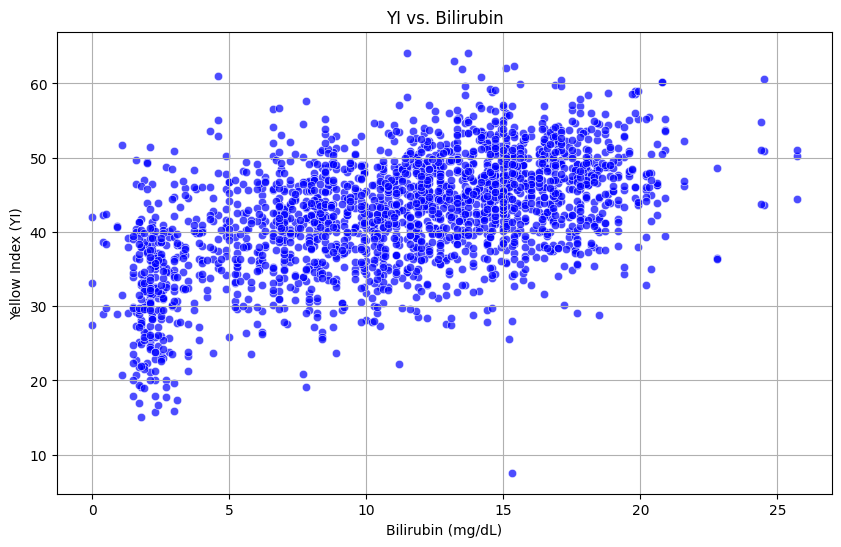

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataf, x='Bilirubin', y='YI', color='blue', alpha=0.7)
plt.title("YI vs. Bilirubin")
plt.xlabel("Bilirubin (mg/dL)")
plt.ylabel("Yellow Index (YI)")
plt.grid(True)
plt.show()

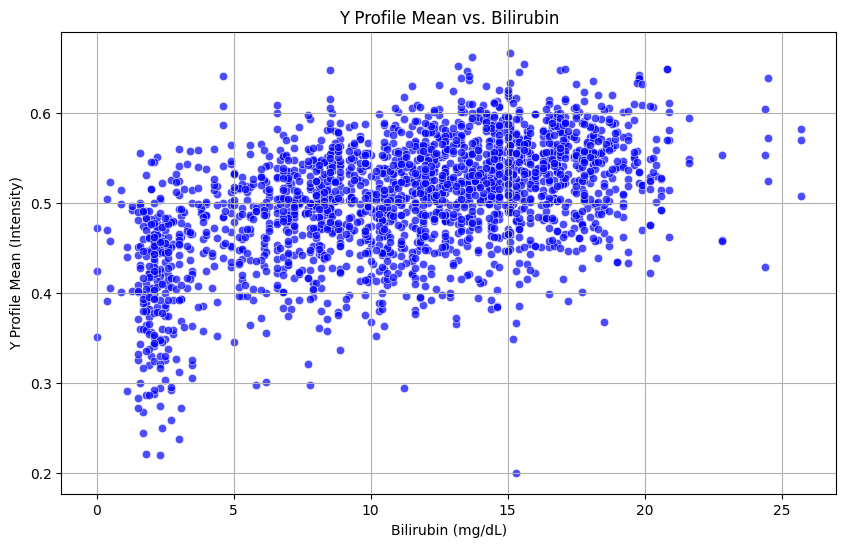

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataf, x='Bilirubin', y='Y Profile Mean', color='blue', alpha=0.7)
plt.title("Y Profile Mean vs. Bilirubin")
plt.xlabel("Bilirubin (mg/dL)")
plt.ylabel("Y Profile Mean (Intensity)")
plt.grid(True)
plt.show()

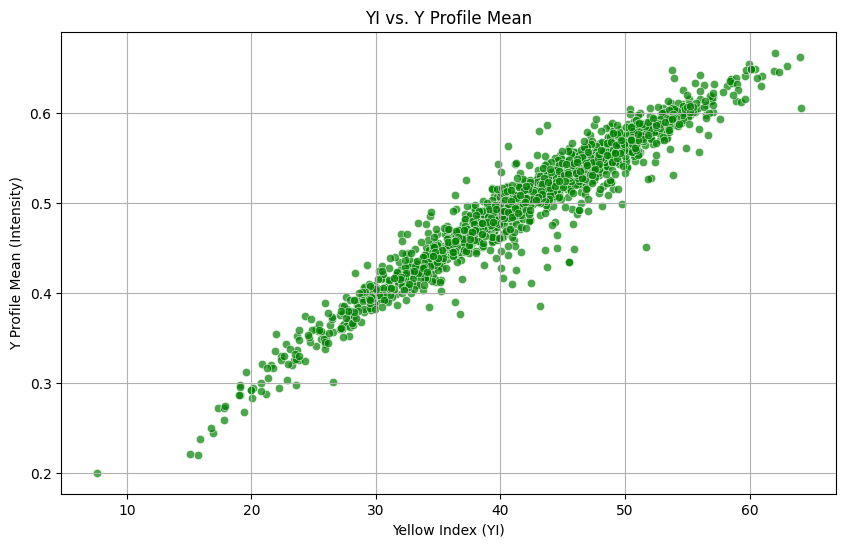

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataf, x='YI', y='Y Profile Mean', color='green', alpha=0.7)
plt.title("YI vs. Y Profile Mean")
plt.xlabel("Yellow Index (YI)")
plt.ylabel("Y Profile Mean (Intensity)")
plt.grid(True)
plt.show()

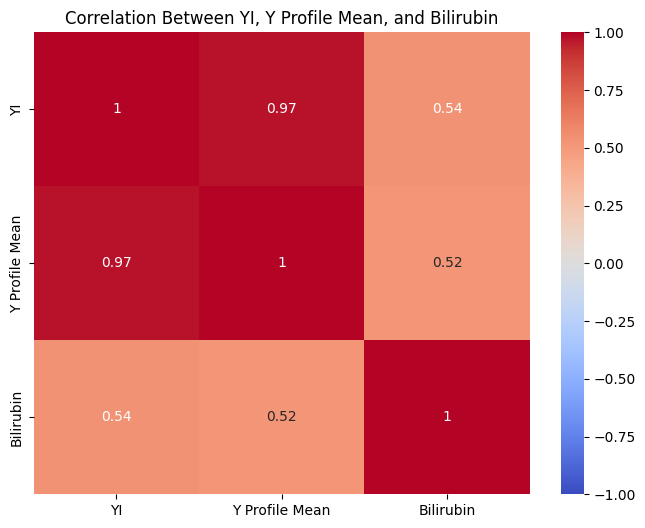

In [ ]:
plt.figure(figsize=(8, 6))
corr = dataf[['YI', 'Y Profile Mean', 'Bilirubin']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between YI, Y Profile Mean, and Bilirubin")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor().fit(dataf[['YI', 'Y Profile Mean']], dataf['Bilirubin'])
print(model.feature_importances_)  # Likely shows redundancy

[0.63617198 0.36382802]


Text(0.5, 1.0, 'Distribution of test')

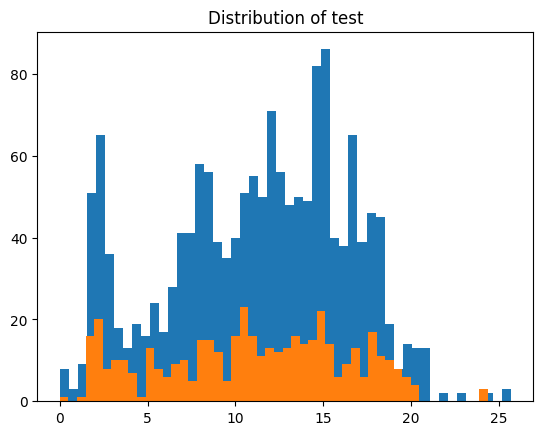

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=50)
plt.title("Distribution of train")

plt.hist(y_test.flatten(), bins=50)
plt.title("Distribution of test")


In [ ]:
import numpy as np

def count_ranges(y_data, data_name):
    y_array = np.array(y_data)
    
    count_0_5 = np.sum((y_array >= 0) & (y_array < 5))
    count_5_10 = np.sum((y_array >= 5) & (y_array <= 10))
    count_above_10 = np.sum(y_array > 10)
    
    total = len(y_array)
    if total > 0:
        perc_0_5 = (count_0_5 / total) * 100
        perc_5_10 = (count_5_10 / total) * 100
        perc_above_10 = (count_above_10 / total) * 100
    else:
        perc_0_5 = perc_5_10 = perc_above_10 = 0
    
    print(f"\n{data_name} (Total: {total})")
    print(f"0-5 mg/dL: {count_0_5} ({perc_0_5:.2f}%)")
    print(f"5-10 mg/dL: {count_5_10} ({perc_5_10:.2f}%)")
    print(f">10 mg/dL: {count_above_10} ({perc_above_10:.2f}%)")

count_ranges(y_train, "Training set")
count_ranges(y_val, "Validation set")
count_ranges(y_test, "Test set")


Training set (Total: 1564)
0-5 mg/dL: 232 (14.83%)
5-10 mg/dL: 376 (24.04%)
>10 mg/dL: 956 (61.13%)

Validation set (Total: 221)
0-5 mg/dL: 35 (15.84%)
5-10 mg/dL: 47 (21.27%)
>10 mg/dL: 139 (62.90%)

Test set (Total: 450)
0-5 mg/dL: 78 (17.33%)
5-10 mg/dL: 108 (24.00%)
>10 mg/dL: 264 (58.67%)


In [ ]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi

def extract_color_features(skin_img):
    features = {}
    b, g, r = cv2.split(skin_img)
    features['rgb'] = [r, g, b]
    hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    features['hsv'] = [h, s, v]
    lab = cv2.cvtColor(skin_img, cv2.COLOR_BGR2LAB)
    l, a, b_lab = cv2.split(lab)
    features['lab'] = [l, a, b_lab]
    ycbcr = cv2.cvtColor(skin_img, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)
    features['ycbcr'] = [y, cb, cr]
    return features

from scipy.stats import skew, kurtosis, entropy
import numpy as np

def extract_pixel_statistics(channel):
    mask = channel > 0
    if np.sum(mask) == 0:
        return np.zeros(18)
    
    pixels = channel[mask]
    hist, _ = np.histogram(pixels, bins=256, range=(0,256))
    hist = hist / hist.sum()
    return np.array([
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels),
        np.median(pixels),
        np.percentile(pixels, 25),
        np.percentile(pixels, 75),
        np.max(pixels) - np.min(pixels),
        np.percentile(pixels, 75) - np.percentile(pixels, 25),  # IQR
        entropy(hist),                                          # Image entropy
        np.sum(hist**2),                                        # Energy
        np.sqrt(np.mean(pixels**2)),                            # RMS
        np.median(np.abs(pixels - np.median(pixels))),          # MAD
        np.std(pixels) / (np.mean(pixels) + 1e-6),              # CoV
        np.percentile(pixels, 10),                              # 10th percentile
        np.percentile(pixels, 90),                              # 90th percentile
        np.argmax(hist),                                        # Mode
        np.var(pixels)                                          # Variance
    ])

def crop_center(img, fraction=0.35):
    h, w = img.shape[:2]
    ch, cw = int(h * fraction), int(w * fraction)
    start_x, start_y = (w - cw) // 2, (h - ch) // 2
    return img[start_y:start_y+ch, start_x:start_x+cw]

def preprocess_images(images):
    all_features = []
    for img in images:
        target_lab_yellow = (233.0, 80.0, 114.0)
        target_lab_white = (255.0, 128.0, 128.0)
        target_lab_black = (0.0, 128.0, 128.0)
        target_lab_red = (136.0, 208.0, 195.0)  


        yellow_mask = extract_yellow_card_mask(img)
        white_mask = extract_white_card_mask(img)
        black_mask = extract_black_card_mask(img)
        red_mask = extract_red_card_mask(img)

        corrected_img = correct_image_color_multicard(
            img, yellow_mask, white_mask, black_mask, red_mask,
            target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
        )
        skin = crop_center(corrected_img)
        color_features = extract_color_features(skin)
        channel_stats = []
        for space in ['rgb', 'hsv']:
            for channel in color_features[space]:
                channel_stats.extend(extract_pixel_statistics(channel))
        all_features.append(channel_stats)
    return np.array(all_features)
print("\nPreprocessing images...")
X = preprocess_images(image_data)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)  

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_val = X_val.reshape(-1, X_val.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

print("\nFinal data shapes:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, InputLayer
from tensorflow.keras.regularizers import l2
def build_1dcnn(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape), 

        Conv1D(32, kernel_size=3, padding='same', activation='relu'), 
        MaxPooling1D(pool_size=2, padding='same'),                    

        Conv1D(64, kernel_size=3, padding='same', activation='relu'),  
        MaxPooling1D(pool_size=2, padding='same'),                    

        Conv1D(128, kernel_size=3, padding='same', activation='relu'), 
        MaxPooling1D(pool_size=2, padding='same'),                      

        Conv1D(128, kernel_size=3, padding='same', activation='relu'),  
        MaxPooling1D(pool_size=2, padding='same'),                     

        Flatten(),                                                  

        Dense(256, activation='relu'),                                
        # Dropout(0.3),                                                 

        Dense(128, activation='relu'),                                
        # Dropout(0.5),                                                  

        Dense(1, activation='linear')                                 
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=10_000,
        decay_rate=0.9)
    
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=['mae'])
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_1dcnn(input_shape)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

# Train model
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)




Preprocessing images...
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more pat


Evaluating on test set...
14/14 [==============================] - 0s 3ms/step

Test Results:
RMSE: 3.230
MAE: 2.474
R²: 0.645


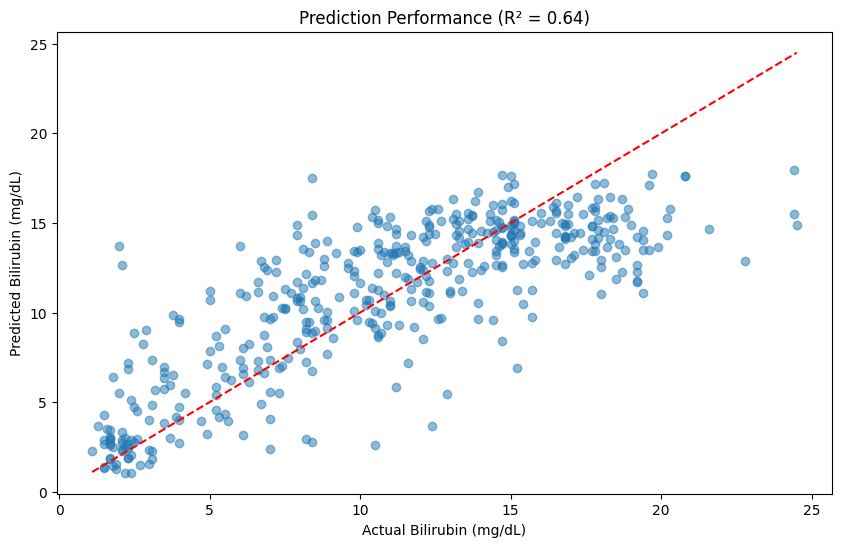

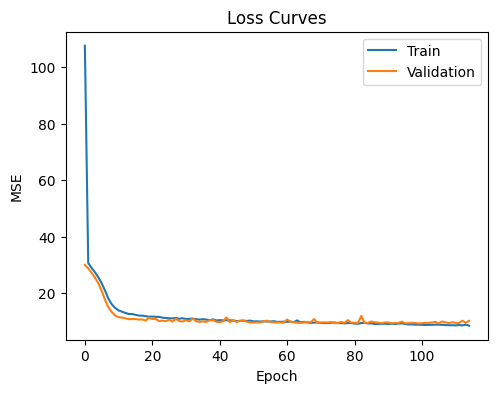

In [ ]:
# Evaluate  
print("\nEvaluating on test set...")
y_pred = model.predict(X_test).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.show()

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
